**Team 6 - Human Fall Detection Using Multimodal Approach**

In [ ]:
import pandas as pd
import os
import numpy as np
import cv2
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
import random as rn
from sklearn.preprocessing import  StandardScaler
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow-addons==0.16.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.4 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten , Input ,BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D , Conv1D , MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix,balanced_accuracy_score
import joblib

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [ ]:
print(SUB.shape)

(294678, 44)


# Data Processing

In [ ]:
SUB.isnull().sum()

Time                              0
X-axis Accelerometer (g)          0
Y-axis Accelerometer (g)          0
Z-axis Accelerometer (g)          0
Roll Gyroscrope (deg/s)           0
Pitch Gyroscope (deg/s)           0
Yaw Gyroscope (deg/s)             0
Luminosity (lux)                  0
X-axis Accelerometer (g).1    36109
Y-axis Accelerometer (g).1    36109
Z-axis Accelerometer (g).1    36109
Roll Gyroscrope (deg/s).1     36109
Pitch Gyroscope (deg/s).1     36109
Yaw Gyroscope (deg/s).1       36109
Luminosity (lux).1            36109
X-axis Accelerometer (g).2        0
Y-axis Accelerometer (g).2        0
Z-axis Accelerometer (g).2        0
Roll Gyroscrope (deg/s).2         0
Pitch Gyroscope (deg/s).2         0
Yaw Gyroscope (deg/s).2           0
Luminosity (lux).2                0
X-axis Accelerometer (g).3        0
Y-axis Accelerometer (g).3        0
Z-axis Accelerometer (g).3        0
Roll Gyroscrope (deg/s).3         0
Pitch Gyroscope (deg/s).3         0
Yaw Gyroscope (deg/s).3     

In [ ]:
NA_cols  = SUB.columns[SUB.isnull().any()]
print('Columns contain NULL values : \n', NA_cols )


SUB.dropna(inplace = True)
SUB.drop_duplicates(inplace = True)
print('Sensor Data shape after dropping NaN and redudant samples :',SUB.shape)


times = SUB['Time']

list_DROP = [ 'Infrared 1',
              'Infrared 2',
              'Infrared 3',
              'Infrared 4',
              'Infrared 5',
              'Infrared 6']
SUB.drop(list_DROP, axis = 1, inplace=  True )
SUB.drop( NA_cols, axis = 1, inplace=  True ) # drop NAN COLS

print('Sensor Data shape after dropping columns contain NaN values :',SUB.shape)

Columns contain NULL values : 
 Index(['X-axis Accelerometer (g).1', 'Y-axis Accelerometer (g).1',
       'Z-axis Accelerometer (g).1', 'Roll Gyroscrope (deg/s).1',
       'Pitch Gyroscope (deg/s).1', 'Yaw Gyroscope (deg/s).1',
       'Luminosity (lux).1', 'Raw Brainwave Signal '],
      dtype='object')
Sensor Data shape after dropping NaN and redudant samples : (258114, 44)
Sensor Data shape after dropping columns contain NaN values : (258114, 30)


In [ ]:
SUB.set_index('Time', inplace = True)
SUB.head()

X-axis Accelerometer (g)  \
Time                                                   
2018-07-04T12:04:17.738369                    -1.005   
2018-07-04T12:04:17.790509                    -1.005   
2018-07-04T12:04:17.836632                    -1.005   
2018-07-04T12:04:17.885262                    -1.005   
2018-07-04T12:04:17.945423                    -1.008   

                            Y-axis Accelerometer (g)  \
Time                                                   
2018-07-04T12:04:17.738369                     0.229   
2018-07-04T12:04:17.790509                     0.228   
2018-07-04T12:04:17.836632                     0.231   
2018-07-04T12:04:17.885262                     0.231   
2018-07-04T12:04:17.945423                     0.229   

                            Z-axis Accelerometer (g)  Roll Gyroscrope (deg/s)  \
Time                                                                            
2018-07-04T12:04:17.738369                    -0.083                   -0.671   
2018-07-04T12:04:17.790509                    -0.082                   -3.415   
2018-07-04T12:04:17.836632                    -0.079                   -2.622   
2018-07-04T12:04:17.885262                    -0.079                   -2.561   
2018-07-04T12:04:17.945423                    -0.072                   -3.537   

                            Pitch Gyroscope (deg/s)  Yaw Gyroscope (deg/s)  \
Time                                                                         
2018-07-04T12:04:17.738369                    0.488                 -2.683   
2018-07-04T12:04:17.790509                   -0.549                  0.122   
2018-07-04T12:04:17.836632                   -1.402                 -0.549   
2018-07-04T12:04:17.885262                   -2.195                 -1.220   
2018-07-04T12:04:17.945423                   -2.073                 -0.305   

                            Luminosity (lux)  X-axis Accelerometer (g).2  \
Time                                                                       
2018-07-04T12:04:17.738369               0.0                       0.146   
2018-07-04T12:04:17.790509               0.0                       0.146   
2018-07-04T12:04:17.836632               0.0                       0.178   
2018-07-04T12:04:17.885262               0.0                       0.160   
2018-07-04T12:04:17.945423               0.0                       0.160   

                            Y-axis Accelerometer (g).2  \
Time                                                     
2018-07-04T12:04:17.738369                       0.895   
2018-07-04T12:04:17.790509                       0.895   
2018-07-04T12:04:17.836632                       0.896   
2018-07-04T12:04:17.885262                       0.895   
2018-07-04T12:04:17.945423                       0.895   

                            Z-axis Accelerometer (g).2  ...  \
Time                                                    ...   
2018-07-04T12:04:17.738369                       0.367  ...   
2018-07-04T12:04:17.790509                       0.367  ...   
2018-07-04T12:04:17.836632                       0.373  ...   
2018-07-04T12:04:17.885262                       0.372  ...   
2018-07-04T12:04:17.945423                       0.372  ...   

                            Yaw Gyroscope (deg/s).3  Luminosity (lux).3  \
Time                                                                      
2018-07-04T12:04:17.738369                    9.207            1231.336   
2018-07-04T12:04:17.790509                    5.122            1231.336   
2018-07-04T12:04:17.836632                    4.329            1231.336   
2018-07-04T12:04:17.885262                    0.366            1231.336   
2018-07-04T12:04:17.945423                   -3.232            1231.336   

                            X-axis Accelerometer (g).4  \
Time                                                     
2018-07-04T12:04:17.738369                      -1.240   
2018-07-04T12:04:17.790509                   

In [ ]:
cam = '1'

image = 'Sensor + Image' + '/' + 'image_' + cam +  '.npy'
name = 'Sensor + Image' + '/' + 'name_' + cam +  '.npy'
label = 'Sensor + Image' + '/' + 'label_' + cam +  '.npy'

img_1 = np.load(image)
label_1 = np.load(label)
name_1 = np.load(name)

cam = '2'

image = 'Sensor + Image' + '/' + 'image_' + cam +  '.npy'
name = 'Sensor + Image' + '/' + 'name_' + cam +  '.npy'
label = 'Sensor + Image' + '/' + 'label_' + cam +  '.npy'

img_2 = np.load(image)
label_2 = np.load(label)
name_2 = np.load(name)



In [ ]:
print(len(img_1))
print(len(name_1))
print(len(img_2))
print(len(name_2))

294677
294677
294677
294677


In [ ]:
# remove NaN values corresponding to index sample in csv file
redundant_1 = list(set(name_1) - set(times))
redundant_2 = list(set(name_2) - set(times))
ind = np.arange(0,294677)


red_in1 = ind[np.isin(name_1,redundant_1)]
name_1 =  np.delete(name_1, red_in1)
img_1 = np.delete(img_1, red_in1, axis = 0 )
label_1 = np.delete(label_1, red_in1)

red_in2 = ind[np.isin(name_2,redundant_2)]
name_2 =  np.delete(name_2, red_in2)
img_2 = np.delete(img_2, red_in2, axis = 0 )
label_2 = np.delete(label_2, red_in2)

In [ ]:
print(len(name_2))
print(len(name_1))

258113
258113


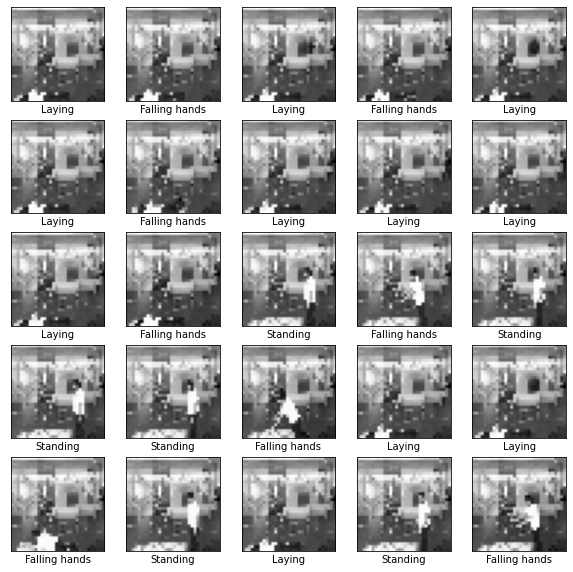

In [ ]:
class_name = [    '?????' ,
                'Falling hands' ,
                 'Falling knees' ,
                 'Falling backwards',
                 'Falling sideward' ,
                ' Falling chair',
                ' Walking',
                 'Standing' ,
                 'Sitting' ,
                 'Picking object' ,
                 'Jumping' ,
                 'Laying' ]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_1[i], cmap = 'gray')
    plt.xlabel(class_name[label_1[i]])
plt.show()

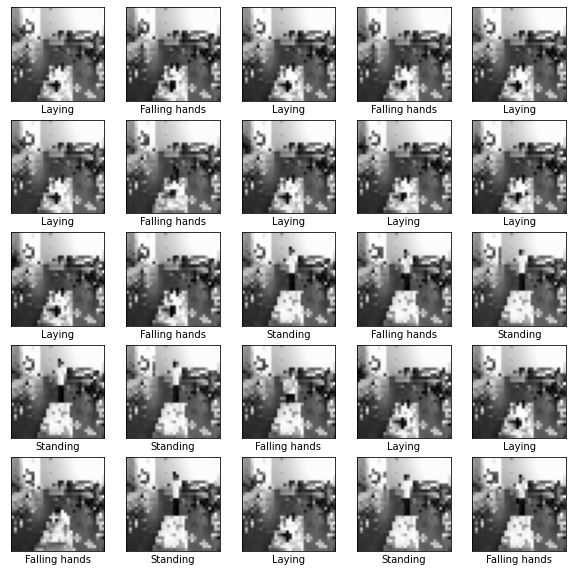

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_2[i], cmap = 'gray')
    plt.xlabel(class_name[label_2[i]])
plt.show()

In [ ]:

data = SUB.loc[name_1].values
print(img_1.shape)
print(img_2.shape)
print(data.shape)


print((label_2 == data[:,-1]).all())
print((label_1 == data[:,-1]).all())

(258113, 32, 32)
(258113, 32, 32)
(258113, 29)
True
True


In [ ]:

def set_seed():
    SEED = 0
    os.environ['PYTHONHASHSEED']=str(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    rn.seed(SEED)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

set_seed()
X_csv, y_csv = data[:,:-1] , data[:,-1]

y_csv = np.where(y_csv == 20 , 0, y_csv)
label_1 = np.where(label_1 == 20 , 0, label_1)
label_2 = np.where(label_2 == 20, 0, label_2)
X_train_csv,X_rem_csv,y_train_csv,y_rem_csv = train_test_split(X_csv, y_csv,
                                                                 train_size = 0.6,
                                                                 random_state = 42)

X_val_csv, X_test_csv, y_val_csv, y_test_csv = train_test_split(X_rem_csv, y_rem_csv,
                                                                  test_size = 0.5,
                                                                  random_state = 42)

print('X_train_csv shape : ',X_train_csv.shape)
print('X_test_csv shape : ',X_test_csv.shape)
print('X_val_csv shape : ',X_val_csv.shape)
print('y_train_csv shape : ',y_train_csv.shape)
print('y_test_csv shape : ',y_test_csv.shape)
print('y_val_csv shape : ',y_val_csv.shape)

Y_train_csv = to_categorical(y_train_csv, 12)
Y_test_csv = to_categorical(y_test_csv, 12)
Y_val_csv = to_categorical(y_val_csv, 12)

print('Y_train_csv shape : ',Y_train_csv.shape)
print('Y_test_csv shape : ',Y_test_csv.shape)
print('Y_val_csv shape : ',Y_val_csv.shape)



X_train_1,X_rem_1,y_train_1,y_rem_1 = train_test_split(img_1,label_1,
                                                         train_size = 0.6,
                                                         random_state = 42,
                                                         )

X_val_1,X_test_1,y_val_1,y_test_1 = train_test_split(X_rem_1,y_rem_1,
                                                         test_size = 0.5,
                                                         random_state = 42,
                                                         )
print('*'*20)
print('X_train_1 shape : ',X_train_1.shape)
print('X_test_1 shape : ',X_test_1.shape)
print('X_val_1 shape : ',X_val_1.shape)
print('y_train_1 shape : ',y_train_1.shape)
print('y_test_1 shape : ',y_test_1.shape)
print('y_val_1 shape : ',y_val_1.shape)


Y_train_1 = to_categorical(y_train_1, 12)
Y_test_1 = to_categorical(y_test_1, 12)
Y_val_1 = to_categorical(y_val_1, 12)

print('Y_train_1 shape : ',Y_train_1.shape)
print('Y_test_1 shape : ',Y_test_1.shape)
print('Y_val_1 shape : ',Y_val_1.shape)



X_train_2,X_rem_2,y_train_2,y_rem_2 = train_test_split(img_2,label_2,
                                                         train_size = 0.6,
                                                         random_state = 42,
                                                         )

X_val_2,X_test_2,y_val_2,y_test_2 = train_test_split(X_rem_2,y_rem_2,
                                                         test_size = 0.5,
                                                         random_state = 42,
                                                         )

print('*'*20)
print('X_train_2 shape : ',X_train_2.shape)
print('X_test_2 shape : ',X_test_2.shape)
print('X_val_2 shape : ',X_val_2.shape)
print('y_train_2 shape : ',y_train_2.shape)
print('y_test_2 shape : ',y_test_2.shape)
print('y_val_2 shape : ',y_val_2.shape)


Y_train_2 = to_categorical(y_train_2, 12)
Y_test_2 = to_categorical(y_test_2, 12)
Y_val_2 = to_categorical(y_val_2, 12)

print('Y_train_2 shape : ',Y_train_2.shape)
print('Y_test_2 shape : ',Y_test_2.shape)
print('Y_val_2 shape : ',Y_val_2.shape)


X_train_csv shape :  (154867, 28)
X_test_csv shape :  (51623, 28)
X_val_csv shape :  (51623, 28)
y_train_csv shape :  (154867,)
y_test_csv shape :  (51623,)
y_val_csv shape :  (51623,)
Y_train_csv shape :  (154867, 12)
Y_test_csv shape :  (51623, 12)
Y_val_csv shape :  (51623, 12)
********************
X_train_1 shape :  (154867, 32, 32)
X_test_1 shape :  (51623, 32, 32)
X_val_1 shape :  (51623, 32, 32)
y_train_1 shape :  (154867,)
y_test_1 shape :  (51623,)
y_val_1 shape :  (51623,)
Y_train_1 shape :  (154867, 12)
Y_test_1 shape :  (51623, 12)
Y_val_1 shape :  (51623, 12)
********************
X_train_2 shape :  (154867, 32, 32)
X_test_2 shape :  (51623, 32, 32)
X_val_2 shape :  (51623, 32, 32)
y_train_2 shape :  (154867,)
y_test_2 shape :  (51623,)
y_val_2 shape :  (51623,)
Y_train_2 shape :  (154867, 12)
Y_test_2 shape :  (51623, 12)
Y_val_2 shape :  (51623, 12)


In [ ]:
print((y_train_1 == y_train_csv).all())
print((y_train_2 == y_train_csv).all())

print((y_val_1 == y_val_csv).all())
print((y_val_2 == y_val_csv).all())

print((y_test_1 == y_test_csv).all())
print((y_test_2 == y_test_csv).all())

True
True
True
True
True
True


In [ ]:
shape1, shape2 = 32,32
X_train_1 = X_train_1.reshape(X_train_1.shape[0], shape1, shape2 ,1)
X_train_2 = X_train_2.reshape(X_train_2.shape[0], shape1, shape2 ,1)
X_val_1 = X_val_1.reshape(X_val_1.shape[0], shape1, shape2 , 1)
X_val_2 = X_val_2.reshape(X_val_2.shape[0], shape1, shape2 , 1)
X_test_1 = X_test_1.reshape(X_test_1.shape[0], shape1, shape2 ,1)
X_test_2 = X_test_2.reshape(X_test_2.shape[0], shape1, shape2 ,1)

In [ ]:
X_train_1_scaled = X_train_1/255.0
X_train_2_scaled = X_train_2/255.0

X_val_1_scaled = X_val_1/255.0
X_val_2_scaled = X_val_2/255.0

X_test_1_scaled = X_test_1/255.0
X_test_2_scaled = X_test_2/255.0

In [ ]:
print(X_train_1_scaled.shape)
print(X_test_1_scaled.shape)
print(X_val_1_scaled.shape)

print(X_train_2_scaled.shape)
print(X_test_2_scaled.shape)
print(X_val_2_scaled.shape)

(154867, 32, 32, 1)
(51623, 32, 32, 1)
(51623, 32, 32, 1)
(154867, 32, 32, 1)
(51623, 32, 32, 1)
(51623, 32, 32, 1)


In [ ]:

def display_result(y_test , y_pred) :
    print('Accuracy score : ', accuracy_score(y_test , y_pred) )
    print('Precision score : ', precision_score(y_test , y_pred, average='weighted'))
    print('Recall score : ', recall_score(y_test , y_pred, average='weighted'))
    print('F1 score : ', f1_score(y_test , y_pred, average='weighted'))


def scaled_data(X_train, X_test, X_val):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)
    return X_train_scaled, X_test_scaled , X_val_scaled


def convert_to_categorical (y_train, y_test, y_val) :
    print('--------------------------To Categorical ---------------------------')
    Y_train = to_categorical(y_train, 12)
    Y_test = to_categorical(y_test, 12)
    Y_val = to_categorical(y_val,12)

    print('Before    : ', y_train[0])
    print('After     : ',Y_train[0])
    return Y_train, Y_test, Y_val


X_train_csv_scaled, X_test_csv_scaled , X_val_csv_scaled = scaled_data(X_train_csv, X_test_csv, X_val_csv)
Y_train_csv , Y_test_csv , Y_val_csv = convert_to_categorical (y_train_csv, y_test_csv, y_val_csv)



--------------------------To Categorical ---------------------------
Before    :  6.0
After     :  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


# Sensor Data

## Multilayer Perceptron

In [ ]:

def csv_MLP(input_shapes):
    set_seed()
    model =  Sequential([
                    Dense(2000, activation = tf.nn.relu, input_shape = (input_shapes,)),
                    BatchNormalization(),
                    Dense(600, activation = tf.nn.relu),
                    BatchNormalization(),
                    Dropout(0.2),
                    Dense(12, activation='softmax'),
                ])
    model.compile(
                  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001 , name = 'Adam'),
                  loss='categorical_crossentropy' ,
                  metrics =[
                           keras.metrics.CategoricalAccuracy( name='categorical_accuracy'),
                           keras.metrics.Precision( name = 'precision' ),
                           keras.metrics.Recall( name = 'recall' ),
                           tfa.metrics.F1Score( num_classes=12,   name = 'f1_score', average='weighted'),
                          ] )
    return model
model_MLP = csv_MLP(X_train_csv_scaled.shape[1])
model_MLP.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2000)              58000     
_________________________________________________________________
batch_normalization (BatchNo (None, 2000)              8000      
_________________________________________________________________
dense_1 (Dense)              (None, 600)               1200600   
_________________________________________________________________
batch_normalization_1 (Batch (None, 600)               2400      
_________________________________________________________________
dropout (Dropout)            (None, 600)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                7212      
Total params: 1,276,212
Trainable params: 1,271,012
Non-trainable params: 5,200
__________________________________________

In [ ]:

f1_callback_MLP = ModelCheckpoint("Saved Model/Experiments/MLP_csv.hdf5",
                              monitor='val_f1_score',
                              verbose=1,
                              save_best_only=True,
                              mode='max')

history_MLP = model_MLP.fit(X_train_csv_scaled,Y_train_csv,
                                      epochs= 150,
                                      batch_size=  2**10,
                                      validation_data=(X_val_csv_scaled,Y_val_csv),
                                      callbacks = [f1_callback_MLP]
                                     )


Epoch 1/150
151/152 [============================>.] - ETA: 0s - loss: 0.2750 - categorical_accuracy: 0.9308 - precision: 0.9518 - recall: 0.9192 - f1_score: 0.9276

/home/tf/.conda/envs/tf2/lib/python3.7/site-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


152/152 [==============================] - 15s 86ms/step - loss: 0.2749 - categorical_accuracy: 0.9309 - precision: 0.9518 - recall: 0.9192 - f1_score: 0.9276 - val_loss: 1.2544 - val_categorical_accuracy: 0.7015 - val_precision: 0.9845 - val_recall: 0.1800 - val_f1_score: 0.6351

Epoch 00001: val_f1_score improved from -inf to 0.63509, saving model to Saved Model/Experiments/MLP_csv.hdf5
Epoch 2/150
152/152 [==============================] - 13s 83ms/step - loss: 0.1184 - categorical_accuracy: 0.9662 - precision: 0.9743 - recall: 0.9594 - f1_score: 0.9644 - val_loss: 0.3571 - val_categorical_accuracy: 0.9399 - val_precision: 0.9787 - val_recall: 0.8619 - val_f1_score: 0.9369

Epoch 00002: val_f1_score improved from 0.63509 to 0.93692, saving model to Saved Model/Experiments/MLP_csv.hdf5
Epoch 3/150
152/152 [==============================] - 13s 83ms/step - loss: 0.0855 - categorical_accuracy: 0.9741 - precision: 0.9798 - recall: 0.9693 - f1_score: 0.9732 - val_loss: 0.1050 - val_categ

In [ ]:
print("best model: ")
model_MLP.load_weights("Saved Model/Experiments/MLP_csv.hdf5")
print('Validation Set')
print(model_MLP.evaluate(X_val_csv_scaled, Y_val_csv))
print('Test Set')
print(model_MLP.evaluate(X_test_csv_scaled, Y_test_csv))


best model: 
Validation Set
1614/1614 [==============================] - 3s 2ms/step - loss: 0.0606 - categorical_accuracy: 0.9907 - precision: 0.9909 - recall: 0.9905 - f1_score: 0.9905
[0.060551222413778305, 0.9906630516052246, 0.9908537864685059, 0.9905274510383606, 0.9904990792274475]
Test Set
1614/1614 [==============================] - 3s 2ms/step - loss: 0.0618 - categorical_accuracy: 0.9904 - precision: 0.9905 - recall: 0.9903 - f1_score: 0.9903
[0.06177337467670441, 0.9903724789619446, 0.9905056953430176, 0.9902563095092773, 0.9902580380439758]


dict_keys(['loss', 'categorical_accuracy', 'precision', 'recall', 'f1_score', 'val_loss', 'val_categorical_accuracy', 'val_precision', 'val_recall', 'val_f1_score'])


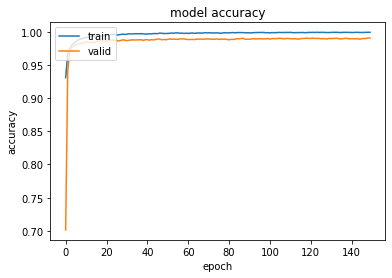

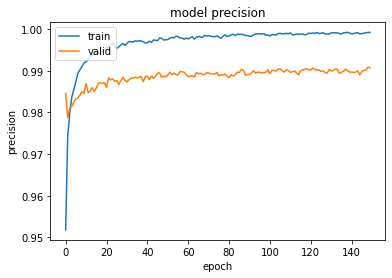

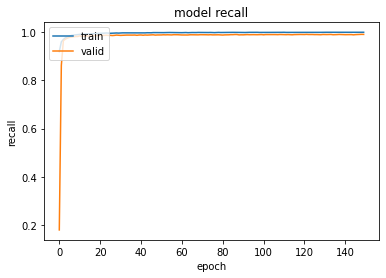

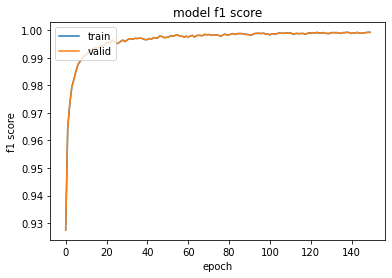

In [ ]:
print(history_MLP.history.keys())
plt.plot(history_MLP.history['categorical_accuracy'])
plt.plot(history_MLP.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()



plt.plot(history_MLP.history['precision'])
plt.plot(history_MLP.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()



plt.plot(history_MLP.history['recall'])
plt.plot(history_MLP.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


plt.plot(history_MLP.history['f1_score'])
plt.plot(history_MLP.history['f1_score'])
plt.title('model f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## XGBBoost

In [ ]:
import xgboost
from xgboost import XGBClassifier


def csv_XGB() :
#     set_seed()
    model_XGB = XGBClassifier(objective="multi:softprob",
                              eta = 0.5,
                              random_state=42,
                              use_label_encoder=False,
                              n_estimators  = 60
                           )
    return model_XGB

model_XGB =  csv_XGB()

model_XGB.fit(
              X = X_train_csv_scaled,
              y =  y_train_csv ,
              eval_set = [(X_train_csv_scaled,y_train_csv) ,(X_val_csv_scaled,y_val_csv)],
              verbose= 1,
              early_stopping_rounds=5,
             )


[15:19:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:0.67665	validation_1-mlogloss:0.69356
[1]	validation_0-mlogloss:0.47278	validation_1-mlogloss:0.49282
[2]	validation_0-mlogloss:0.35109	validation_1-mlogloss:0.37422
[3]	validation_0-mlogloss:0.27121	validation_1-mlogloss:0.29593
[4]	validation_0-mlogloss:0.21483	validation_1-mlogloss:0.24047
[5]	validation_0-mlogloss:0.17486	validation_1-mlogloss:0.20128
[6]	validation_0-mlogloss:0.14380	validation_1-mlogloss:0.17106
[7]	validation_0-mlogloss:0.12029	validation_1-mlogloss:0.14905
[8]	validation_0-mlogloss:0.10043	validation_1-mlogloss:0.12968
[9]	validation_0-mlogloss:0.08752	validation_1-mlogloss:0.11685
[10]	validation_0-mlogloss:0.07582	validation_1-mlogloss:0.10518
[11]	validation_0-mlogloss:0.06494	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.5, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=60, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [ ]:
print('---------------------Test Set--------------------------')
y_pred_csv_XGB = model_XGB.predict(X_test_csv_scaled)
display_result(y_test_csv, y_pred_csv_XGB)

---------------------Test Set--------------------------
Accuracy score :  0.9921352885341805
Precision score :  0.9919991563290247
Recall score :  0.9921352885341805
F1 score :  0.9920019481790098


In [ ]:
filename = 'Saved Model/Experiments/XGB_model.sav'
joblib.dump(model_XGB, filename)
loaded_XGB_model = joblib.load(filename)

y_pred_csv_XGB = loaded_XGB_model.predict(X_test_csv_scaled)
display_result(y_test_csv, y_pred_csv_XGB)

Accuracy score :  0.9921352885341805
Precision score :  0.9919991563290247
Recall score :  0.9921352885341805
F1 score :  0.9920019481790098


## CATBOOST

In [ ]:
from catboost import CatBoostClassifier
def csv_CatBoost():
    model  = CatBoostClassifier(
                                n_estimators=500,
                                random_seed= 42,
                                learning_rate=0.25,
                                max_depth = 12,
                                )
    return model

model_catboost = csv_CatBoost()

model_catboost .fit(
    X_train_csv_scaled,
    y_train_csv,
    eval_set=(X_val_csv_scaled, y_val_csv),
    verbose= 1 ,
    early_stopping_rounds= 5
)



0:	learn: 0.8702462	test: 0.8745435	best: 0.8745435 (0)	total: 1.89s	remaining: 15m 42s
1:	learn: 0.6868242	test: 0.6929683	best: 0.6929683 (1)	total: 3.7s	remaining: 15m 20s
2:	learn: 0.5648195	test: 0.5718845	best: 0.5718845 (2)	total: 5.5s	remaining: 15m 11s
3:	learn: 0.4799517	test: 0.4886897	best: 0.4886897 (3)	total: 7.29s	remaining: 15m 4s
4:	learn: 0.4138388	test: 0.4242951	best: 0.4242951 (4)	total: 9.14s	remaining: 15m 5s
5:	learn: 0.3637087	test: 0.3754206	best: 0.3754206 (5)	total: 10.9s	remaining: 14m 59s
6:	learn: 0.3225172	test: 0.3351432	best: 0.3351432 (6)	total: 12.7s	remaining: 14m 54s
7:	learn: 0.2857062	test: 0.2998267	best: 0.2998267 (7)	total: 14.6s	remaining: 14m 56s
8:	learn: 0.2587435	test: 0.2745320	best: 0.2745320 (8)	total: 16.4s	remaining: 14m 55s
9:	learn: 0.2397674	test: 0.2564500	best: 0.2564500 (9)	total: 18.2s	remaining: 14m 49s
10:	learn: 0.2255793	test: 0.2429851	best: 0.2429851 (10)	total: 19.9s	remaining: 14m 45s
11:	learn: 0.2071352	test: 0.22559

In [ ]:
print('---------------------Test Set--------------------------')
y_pred_csv_catboost = model_catboost.predict(X_test_csv_scaled)
display_result(y_test_csv, y_pred_csv_catboost)


---------------------Test Set--------------------------
Accuracy score :  0.990546849272611
Precision score :  0.9902649653012341
Recall score :  0.990546849272611
F1 score :  0.9902817762782822


In [ ]:
filename = 'Saved Model/Experiments/Catboost_model.sav'
joblib.dump(model_catboost, filename)
loaded_catboost_model = joblib.load(filename)

y_pred_csv_catboost = loaded_catboost_model.predict(X_test_csv_scaled)
display_result(y_test_csv, y_pred_csv_catboost)

Accuracy score :  0.990546849272611
Precision score :  0.9902649653012341
Recall score :  0.990546849272611
F1 score :  0.9902817762782822


# IMAGE 1

In [ ]:
print('X_train_1 shape : ',X_train_1.shape)
print('X_test_1 shape : ',X_test_1.shape)
print('X_val_1 shape : ',X_val_1.shape)
print('y_train_1 shape : ',y_train_1.shape)
print('y_test_1 shape : ',y_test_1.shape)
print('y_val_1 shape : ',y_val_1.shape)

print('Y_train_1 shape : ',Y_train_1.shape)
print('Y_test_1 shape : ',Y_test_1.shape)
print('Y_val_1 shape : ',Y_val_1.shape)

X_train_1 shape :  (154867, 32, 32)
X_test_1 shape :  (51623, 32, 32)
X_val_1 shape :  (51623, 32, 32)
y_train_1 shape :  (154867,)
y_test_1 shape :  (51623,)
y_val_1 shape :  (51623,)
Y_train_1 shape :  (154867, 12)
Y_test_1 shape :  (51623, 12)
Y_val_1 shape :  (51623, 12)


In [ ]:



def img1_CNN(shape_1, shape_2):
    set_seed()

    input = Input(shape=  (shape_1, shape_2, 1) )
    conv = Conv2D(filters = 16,
                  kernel_size = (3,3) ,
                  activation = tf.nn.relu )(input)

    conv = BatchNormalization()(conv)
    conv = MaxPooling2D(pool_size=(2, 2))(conv)
    conv = Flatten()(conv)
    fc = Dense(units = 200,
               activation = tf.nn.relu)(conv)

    dropout = Dropout(rate = 0.2)(fc)
    softmax = Dense(units = 12 ,
                    activation = tf.nn.softmax)(dropout)
    model = Model(inputs = input, outputs = softmax)

    model.compile(
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001 , name = 'Adam'),
              loss = 'categorical_crossentropy' ,
              metrics =[
                       keras.metrics.CategoricalAccuracy(name='categorical_accuracy') ,
                       keras.metrics.Precision(name='precision'),
                       keras.metrics.Recall(name='recall'),
                       tfa.metrics.F1Score( num_classes=12,
                                           name = 'f1_score',
                                           average='weighted'),

              ])
    return  model

model_img1 = img1_CNN(32,32)
model_img1.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 16)        160       
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3600)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               720200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0     

In [ ]:


filepath = 'Saved Model/Experiments/CNN_img1.hdf5'
f1_callback1 = ModelCheckpoint(filepath,
                              monitor='val_f1_score',
                              verbose=1,
                              save_best_only=True,
                              mode='max')

history_img1 =model_img1.fit(
                                X_train_1_scaled,Y_train_1,
                                epochs=30,
                                batch_size=  2**10,
                                validation_data=(X_val_1_scaled,Y_val_1),
                                callbacks = [f1_callback1]
                )



Epoch 1/30
152/152 [==============================] - ETA: 0s - loss: 0.4208 - categorical_accuracy: 0.8845 - precision: 0.9180 - recall: 0.8620 - f1_score: 0.8748

/home/tf/.conda/envs/tf2/lib/python3.7/site-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


152/152 [==============================] - 70s 447ms/step - loss: 0.4208 - categorical_accuracy: 0.8845 - precision: 0.9180 - recall: 0.8620 - f1_score: 0.8748 - val_loss: 1.7059 - val_categorical_accuracy: 0.9375 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.9258

Epoch 00001: val_f1_score improved from -inf to 0.92584, saving model to Saved Model/Experiments/CNN_img1.hdf5
Epoch 2/30
152/152 [==============================] - 68s 446ms/step - loss: 0.1065 - categorical_accuracy: 0.9703 - precision: 0.9803 - recall: 0.9625 - f1_score: 0.9664 - val_loss: 0.9063 - val_categorical_accuracy: 0.9721 - val_precision: 0.9999 - val_recall: 0.3070 - val_f1_score: 0.9685

Epoch 00002: val_f1_score improved from 0.92584 to 0.96854, saving model to Saved Model/Experiments/CNN_img1.hdf5
Epoch 3/30
152/152 [==============================] - 68s 445ms/step - loss: 0.0735 - categorical_accuracy: 0.9788 - precision: 0.9850 - recall: 0.9734 - f1_score: 0.9770 - val_loss: 0.2390 

dict_keys(['loss', 'categorical_accuracy', 'precision', 'recall', 'f1_score', 'val_loss', 'val_categorical_accuracy', 'val_precision', 'val_recall', 'val_f1_score'])


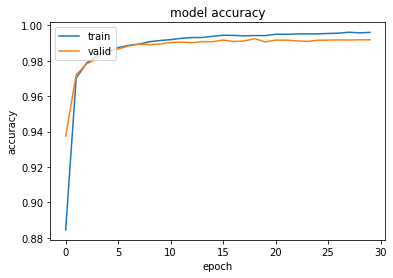

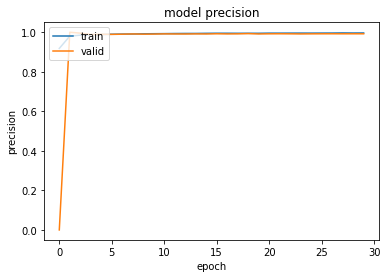

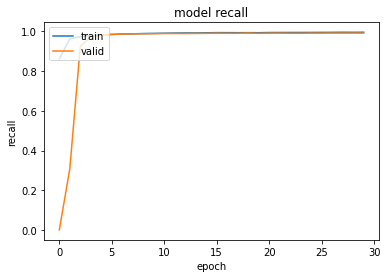

In [ ]:
print(history_img1.history.keys())
plt.plot(history_img1.history['categorical_accuracy'])
plt.plot(history_img1.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()



plt.plot(history_img1.history['precision'])
plt.plot(history_img1.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()



plt.plot(history_img1.history['recall'])
plt.plot(history_img1.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
print("best model: ")
model_img1.load_weights('Saved Model/Experiments/CNN_img1.hdf5')
print(model_img1.evaluate(X_val_1_scaled, Y_val_1))
print(model_img1.evaluate(X_test_1_scaled, Y_test_1))

best model: 
  40/1614 [..............................] - ETA: 6s - loss: 0.0262 - categorical_accuracy: 0.9906 - precision: 0.9906 - recall: 0.9898 - f1_score: 0.9914

/home/tf/.conda/envs/tf2/lib/python3.7/site-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


1614/1614 [==============================] - 7s 5ms/step - loss: 0.0237 - categorical_accuracy: 0.9925 - precision: 0.9930 - recall: 0.9919 - f1_score: 0.9925
[0.023703033104538918, 0.9925227165222168, 0.9930188059806824, 0.9919415712356567, 0.9924643039703369]
1614/1614 [==============================] - 7s 4ms/step - loss: 0.0246 - categorical_accuracy: 0.9917 - precision: 0.9924 - recall: 0.9912 - f1_score: 0.9916
[0.024618441238999367, 0.9916703701019287, 0.9923779368400574, 0.9911860823631287, 0.9916131496429443]


# IMAGE 2

In [ ]:
print('X_train_2 shape : ',X_train_2.shape)
print('X_test_2 shape : ',X_test_2.shape)
print('X_val_2 shape : ',X_val_2.shape)
print('y_train_2 shape : ',y_train_2.shape)
print('y_test_2 shape : ',y_test_2.shape)
print('y_val_2 shape : ',y_val_2.shape)

print('Y_train_2 shape : ',Y_train_2.shape)
print('Y_test_2 shape : ',Y_test_2.shape)
print('Y_val_2 shape : ',Y_val_2.shape)

X_train_2 shape :  (154867, 32, 32)
X_test_2 shape :  (51623, 32, 32)
X_val_2 shape :  (51623, 32, 32)
y_train_2 shape :  (154867,)
y_test_2 shape :  (51623,)
y_val_2 shape :  (51623,)
Y_train_2 shape :  (154867, 12)
Y_test_2 shape :  (51623, 12)
Y_val_2 shape :  (51623, 12)


In [ ]:
def img2_CNN(shape_1, shape_2):
    set_seed()

    input = Input(shape=  (shape_1, shape_2, 1) )
    conv = Conv2D(filters = 18 ,
                  kernel_size = (3,3) ,
                  activation = tf.nn.relu )(input)
    conv = BatchNormalization()(conv)
    conv = MaxPooling2D(pool_size=(2, 2))(conv)
    conv = Flatten()(conv)
    fc = Dense(units = 100,
               activation = tf.nn.relu)(conv)
    dropout = Dropout(rate = 0.2)(fc)
    softmax = Dense(units = 12 ,
                    activation = tf.nn.softmax)(dropout)
    model = Model(inputs = input, outputs = softmax)

    model.compile(
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001 , name = 'Adam'),
              loss = 'categorical_crossentropy' ,
              metrics =[
                       keras.metrics.CategoricalAccuracy(name='categorical_accuracy') ,
                       keras.metrics.Precision(name='precision'),
                       keras.metrics.Recall(name='recall'),
                       tfa.metrics.F1Score( num_classes=12,   name = 'f1_score', average='weighted'),

              ])
    return  model

model_img2 = img2_CNN(32,32)
model_img2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 18)        180       
_________________________________________________________________
batch_normalization_3 (Batch (None, 30, 30, 18)        72        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 18)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4050)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               405100    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0   

In [ ]:


f1_callback2 = ModelCheckpoint("Saved Model/Experiments/CNN_img2.hdf5",
                              monitor='val_f1_score',
                              verbose=1,
                              save_best_only=True,
                              mode='max')

history_img2 =model_img2.fit(
                                X_train_2_scaled,Y_train_2,
                                epochs=30,
                                batch_size=  2**10,
                                validation_data=(X_val_2_scaled,Y_val_2),
                                callbacks = [f1_callback2]
                )


Epoch 1/30
152/152 [==============================] - 75s 491ms/step - loss: 0.2955 - categorical_accuracy: 0.9167 - precision: 0.9485 - recall: 0.8958 - f1_score: 0.9062 - val_loss: 1.4350 - val_categorical_accuracy: 0.9187 - val_precision: 1.0000 - val_recall: 0.0062 - val_f1_score: 0.9090

Epoch 00001: val_f1_score improved from -inf to 0.90904, saving model to Saved Model/Experiments/CNN_img2.hdf5
Epoch 2/30
152/152 [==============================] - 75s 491ms/step - loss: 0.0905 - categorical_accuracy: 0.9740 - precision: 0.9841 - recall: 0.9657 - f1_score: 0.9703 - val_loss: 0.6976 - val_categorical_accuracy: 0.9488 - val_precision: 1.0000 - val_recall: 0.5796 - val_f1_score: 0.9450

Epoch 00002: val_f1_score improved from 0.90904 to 0.94498, saving model to Saved Model/Experiments/CNN_img2.hdf5
Epoch 3/30
152/152 [==============================] - 75s 492ms/step - loss: 0.0642 - categorical_accuracy: 0.9804 - precision: 0.9867 - recall: 0.9749 - f1_score: 0.9788 - val_loss: 0.16

dict_keys(['loss', 'categorical_accuracy', 'precision', 'recall', 'f1_score', 'val_loss', 'val_categorical_accuracy', 'val_precision', 'val_recall', 'val_f1_score'])


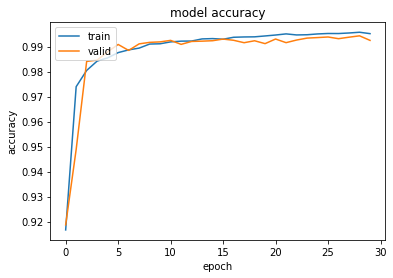

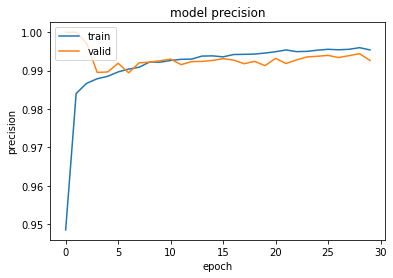

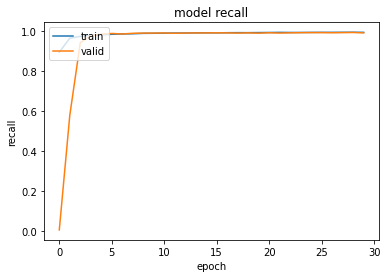

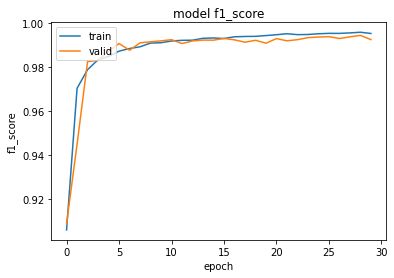

In [ ]:
print(history_img2.history.keys())
plt.plot(history_img2.history['categorical_accuracy'])
plt.plot(history_img2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(history_img2.history['precision'])
plt.plot(history_img2.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(history_img2.history['recall'])
plt.plot(history_img2.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


plt.plot(history_img2.history['f1_score'])
plt.plot(history_img2.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


In [ ]:
print("best model: ")
model_img2.load_weights("Saved Model/Experiments/CNN_img2.hdf5")
print(model_img2.evaluate(X_val_2_scaled, Y_val_2))
print(model_img2.evaluate(X_test_2_scaled, Y_test_2))

best model: 
1614/1614 [==============================] - 8s 5ms/step - loss: 0.0168 - categorical_accuracy: 0.9943 - precision: 0.9944 - recall: 0.9942 - f1_score: 0.9943
[0.016773764044046402, 0.9942854642868042, 0.9944199919700623, 0.9942273497581482, 0.9942758083343506]
1614/1614 [==============================] - 8s 5ms/step - loss: 0.0175 - categorical_accuracy: 0.9940 - precision: 0.9941 - recall: 0.9939 - f1_score: 0.9940
[0.017540093511343002, 0.993994951248169, 0.9940523505210876, 0.9939368367195129, 0.9940016269683838]


# IMG1 + IMG2

In [ ]:
def concatenate_IMG(shape1, shape2) :
    set_seed()
    #------------------------------------------
    input1 = Input(shape = (shape1, shape2, 1))
    conv1 = Conv2D(filters = 16 ,
                   kernel_size = (3, 3) ,
                   activation = tf.nn.relu )(input1)
    conv1 = MaxPooling2D(pool_size = (2,2))(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Flatten()(conv1)
    #------------------------------------------
    input2 = Input( shape = (shape1, shape2, 1))
    conv2 = Conv2D(filters = 16 ,
                   kernel_size = (3, 3) ,
                   activation= tf.nn.relu )(input2)
    conv2 = MaxPooling2D(2, 2)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Flatten()(conv2)
    #------------------------------------------
    concat = Concatenate(axis=1)([conv1, conv2])
    concat = Dense(units = 400 ,
                   activation = tf.nn.relu)(concat)
    concat = Dense(units = 200 ,
                   activation = tf.nn.relu)(concat)
    dropout = Dropout(0.2)(concat)
    softmax = Dense(12, activation = tf.nn.softmax )(dropout)
    model = Model(inputs=[input1, input2], outputs=softmax)

    model.compile(
                 optimizer = tf.keras.optimizers.Adam(0.001),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,
                                                name = 'f1_score',
                                                average='weighted')]  )

    return model


In [ ]:
shape1 ,shape2 = 32, 32
model_img12 = concatenate_IMG(shape1, shape2)

In [ ]:
model_img12.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 30, 30, 16)   160         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 30, 30, 16)   160         input_4[0][0]                    
____________________________________________________________________________________________

In [ ]:

f1_callback_img12 = ModelCheckpoint("Saved Model/Experiments/model_img12.hdf5",
                              monitor='val_f1_score',
                              verbose=1,
                              save_best_only=True,
                              mode='max')
history_img12 = model_img12.fit(x = [X_train_1_scaled, X_train_2_scaled],
                      y=  Y_train_1,
                      epochs=30,
                      batch_size = 2**10 ,
                      validation_data = ([X_val_1_scaled, X_val_2_scaled] , Y_val_1),
                      callbacks = [f1_callback_img12]
                     )



Epoch 1/30
152/152 [==============================] - 72s 468ms/step - loss: 0.3561 - categorical_accuracy: 0.9100 - precision: 0.9372 - recall: 0.8952 - f1_score: 0.9041 - val_loss: 1.4151 - val_categorical_accuracy: 0.8768 - val_precision: 1.0000 - val_recall: 0.0271 - val_f1_score: 0.8729

Epoch 00001: val_f1_score improved from -inf to 0.87288, saving model to Saved Model/Experiments/model_img12.hdf5
Epoch 2/30
152/152 [==============================] - 70s 461ms/step - loss: 0.0571 - categorical_accuracy: 0.9830 - precision: 0.9877 - recall: 0.9780 - f1_score: 0.9818 - val_loss: 0.5422 - val_categorical_accuracy: 0.9558 - val_precision: 0.9993 - val_recall: 0.7317 - val_f1_score: 0.9564

Epoch 00002: val_f1_score improved from 0.87288 to 0.95640, saving model to Saved Model/Experiments/model_img12.hdf5
Epoch 3/30
152/152 [==============================] - 70s 460ms/step - loss: 0.0360 - categorical_accuracy: 0.9888 - precision: 0.9908 - recall: 0.9867 - f1_score: 0.9884 - val_loss

In [ ]:
print("best model: ")
model_img12.load_weights("Saved Model/Experiments/model_img12.hdf5")
print(model_img12.evaluate([X_val_1_scaled, X_val_2_scaled] , Y_val_1))
print(model_img12.evaluate([X_test_1_scaled, X_test_2_scaled] , Y_test_1))



best model: 
1614/1614 [==============================] - 9s 6ms/step - loss: 0.0182 - categorical_accuracy: 0.9952 - precision: 0.9953 - recall: 0.9951 - f1_score: 0.9951
[0.01819441467523575, 0.9951571822166443, 0.995272696018219, 0.9951184391975403, 0.9951376914978027]
1614/1614 [==============================] - 9s 6ms/step - loss: 0.0202 - categorical_accuracy: 0.9947 - precision: 0.9947 - recall: 0.9946 - f1_score: 0.9947
[0.02024143934249878, 0.9946922659873962, 0.9947112202644348, 0.9946341514587402, 0.9946966767311096]


# CONCATENATE

In [ ]:
def model_csv_img (num_csv_features , img_shape1, img_shape2):
    set_seed()

    inputs1 = Input(shape= ( num_csv_features ,1 ) )
    conv1 = Conv1D(filters=10, kernel_size=3, activation='relu')(inputs1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    batch1 = BatchNormalization()(pool1)
    flat1 = Flatten()(batch1)
    #--------------------------
    inputs2 = Input(shape=  (img_shape1, img_shape2, 1) )
    conv2 = Conv2D(filters = 16 ,
                   kernel_size = (3, 3),
                   activation=  tf.nn.relu )(inputs2)
    pool2 = MaxPooling2D(pool_size = (2,2))(conv2)
    batch2 = BatchNormalization()(pool2)
    flat2 = Flatten()(batch2)
    #--------------------------
    inputs3 = Input(shape=  (img_shape1, img_shape2, 1) )
    conv3 = Conv2D(16 ,(3, 3), activation='relu')(inputs3)
    pool3 = MaxPooling2D(pool_size = (2,2))(conv3)
    batch3 = BatchNormalization()(pool3)
    flat3 = Flatten()(batch3)
    #--------------------------
    merged = Concatenate(axis=1)([flat1, flat2,flat3])
    dense1 = Dense(units = 600, activation='relu')(merged)
    dense2 = Dense(units = 1200, activation='relu')(dense1)
    dropout = Dropout(0.2)(dense2)
    outputs = Dense(12, activation='softmax')(dropout)
    model  = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)

    model.compile(
                 optimizer = tf.keras.optimizers.Adam(0.001),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,
                                                name = 'f1_score',
                                                average='weighted')
                           ]
    )

    return model

In [ ]:
model_concatenate = model_csv_img (X_train_csv_scaled.shape[1] ,
                                   32,
                                   32)

In [ ]:
model_concatenate.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 26, 10)       40          input_9[0][0]                    
____________________________________________________________________________________________

In [ ]:


f1_callback_concat = ModelCheckpoint("Saved Model/Experiments/model_concatenate.hdf5",
                              monitor='val_f1_score',
                              verbose=1,
                              save_best_only=True,
                              mode='max')
history_concatenate = model_concatenate.fit(x = [X_train_csv_scaled,X_train_1_scaled, X_train_2_scaled],
                      y=  Y_train_csv,
                      epochs= 30,
                      batch_size = 2**10 ,
                      validation_data = ([X_val_csv_scaled,X_val_1_scaled, X_val_2_scaled] , Y_val_csv),
                      callbacks = [f1_callback_concat]
                     )



Epoch 1/30
152/152 [==============================] - ETA: 0s - loss: 0.3479 - categorical_accuracy: 0.9222 - precision: 0.9475 - recall: 0.9070 - f1_score: 0.9177

/home/tf/.conda/envs/tf2/lib/python3.7/site-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


152/152 [==============================] - 85s 556ms/step - loss: 0.3479 - categorical_accuracy: 0.9222 - precision: 0.9475 - recall: 0.9070 - f1_score: 0.9177 - val_loss: 0.8860 - val_categorical_accuracy: 0.9437 - val_precision: 0.9989 - val_recall: 0.4458 - val_f1_score: 0.9433

Epoch 00001: val_f1_score improved from -inf to 0.94333, saving model to Saved Model/Experiments/model_concatenate.hdf5
Epoch 2/30
152/152 [==============================] - 84s 551ms/step - loss: 0.0382 - categorical_accuracy: 0.9876 - precision: 0.9906 - recall: 0.9845 - f1_score: 0.9872 - val_loss: 0.1895 - val_categorical_accuracy: 0.9694 - val_precision: 0.9896 - val_recall: 0.9375 - val_f1_score: 0.9679

Epoch 00002: val_f1_score improved from 0.94333 to 0.96791, saving model to Saved Model/Experiments/model_concatenate.hdf5
Epoch 3/30
152/152 [==============================] - 84s 552ms/step - loss: 0.0219 - categorical_accuracy: 0.9926 - precision: 0.9935 - recall: 0.9917 - f1_score: 0.9925 - val_los

dict_keys(['loss', 'categorical_accuracy', 'precision', 'recall', 'f1_score', 'val_loss', 'val_categorical_accuracy', 'val_precision', 'val_recall', 'val_f1_score'])


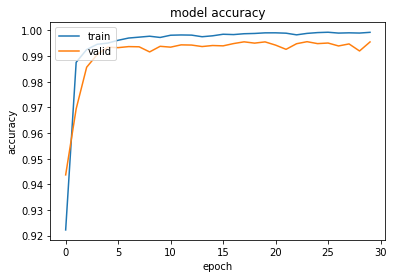

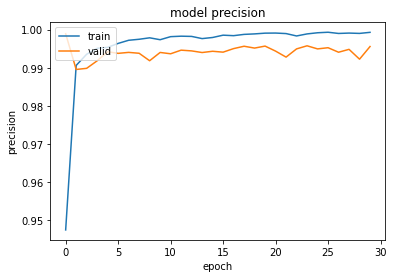

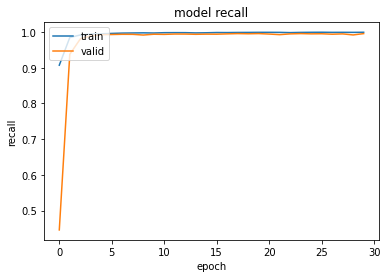

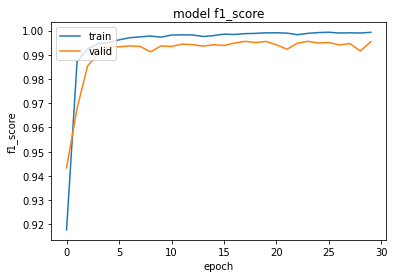

In [ ]:
print(history_concatenate.history.keys())
plt.plot(history_concatenate.history['categorical_accuracy'])
plt.plot(history_concatenate.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(history_concatenate.history['precision'])
plt.plot(history_concatenate.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(history_concatenate.history['recall'])
plt.plot(history_concatenate.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


plt.plot(history_concatenate.history['f1_score'])
plt.plot(history_concatenate.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


In [ ]:
print("best model: ")
model_concatenate.load_weights("Saved Model/Experiments/model_concatenate.hdf5")
print(model_concatenate.evaluate([X_val_csv_scaled, X_val_1_scaled, X_val_2_scaled] , Y_val_1))
print(model_concatenate.evaluate([X_test_csv_scaled, X_test_1_scaled, X_test_2_scaled] , Y_test_1))


best model: 
1614/1614 [==============================] - 12s 7ms/step - loss: 0.0186 - categorical_accuracy: 0.9956 - precision: 0.9958 - recall: 0.9955 - f1_score: 0.9956
[0.018562886863946915, 0.9956220984458923, 0.9957565665245056, 0.9954864978790283, 0.9955587387084961]
1614/1614 [==============================] - 12s 7ms/step - loss: 0.0178 - categorical_accuracy: 0.9956 - precision: 0.9957 - recall: 0.9956 - f1_score: 0.9955
[0.017761187627911568, 0.9956027269363403, 0.9956991672515869, 0.9956027269363403, 0.9955457448959351]


# Comparing with different model

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
def csv_RandomForest():
    model = RandomForestClassifier(n_estimators = 10,
                                   min_samples_split = 2,
                                   min_samples_leaf = 1,
                                   bootstrap = True,
                                   random_state = 0
                                    )
    return model


In [ ]:
model_RF = csv_RandomForest()
model_RF.fit(X_train_csv_scaled, y_train_csv)
y_pred_RandomForest = model_RF.predict(X_test_csv_scaled)
display_result(y_test_csv,y_pred_RandomForest)

Accuracy score :  0.9746430854464095
Precision score :  0.97299353092025
Recall score :  0.9746430854464095
F1 score :  0.9728036654461721


In [ ]:
filename = 'Saved Model/Paper/RandomForest_model.sav'
joblib.dump(model_RF, filename)
loaded_RF_model = joblib.load(filename)

y_pred_csv_RandomForest = loaded_RF_model.predict(X_test_csv_scaled)
display_result(y_test_csv, y_pred_csv_RandomForest)

Accuracy score :  0.9746430854464095
Precision score :  0.97299353092025
Recall score :  0.9746430854464095
F1 score :  0.9728036654461721


## SVM

In [ ]:
from sklearn import svm
def csv_SVM():
    model = svm.SVC(C = 1,
                kernel = 'rbf',
                gamma  = 'auto',
                shrinking  = True,
                tol = 0.001,
                random_state = 0
                )
    return model




In [ ]:
model_SVM = csv_SVM()
model_SVM.fit(X_train_csv_scaled, y_train_csv)
y_pred_SVM = model_SVM.predict(X_test_csv_scaled)
display_result(y_test_csv,y_pred_SVM)

Accuracy score :  0.9696840555566317
Precision score :  0.9682218625909775
Recall score :  0.9696840555566317
F1 score :  0.9661331258667356


In [ ]:
filename = 'Saved Model/Paper/SVM_model.sav'
joblib.dump(model_SVM, filename)
loaded_SVM_model = joblib.load(filename)

y_pred_csv_SVM = loaded_SVM_model.predict(X_test_csv_scaled)
display_result(y_test_csv, y_pred_csv_SVM)

Accuracy score :  0.9696840555566317
Precision score :  0.9682218625909775
Recall score :  0.9696840555566317
F1 score :  0.9661331258667356


## kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
def csv_kNN():
    model = KNeighborsClassifier(n_neighbors=5,
                                 leaf_size = 30,
                                 metric = 'euclidean')
    return model



In [ ]:
model_kNN = csv_kNN()
model_kNN.fit(X_train_csv_scaled, y_train_csv)
y_pred_kNN = model_kNN.predict(X_test_csv_scaled)
display_result(y_test_csv,y_pred_kNN)

Accuracy score :  0.9724735098696318
Precision score :  0.9707220537176988
Recall score :  0.9724735098696318
F1 score :  0.9705624147721252


In [ ]:
filename = 'Saved Model/Paper/KNN_model.sav'
joblib.dump(model_kNN, filename)
loaded_KNN_model = joblib.load(filename)

y_pred_csv_KNN = loaded_KNN_model.predict(X_test_csv_scaled)
display_result(y_test_csv, y_pred_csv_KNN)

Accuracy score :  0.9724735098696318
Precision score :  0.9707220537176988
Recall score :  0.9724735098696318
F1 score :  0.9705624147721252


## MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

def csv_MLP():
    model = MLPClassifier(hidden_layer_sizes=(100,),
                          activation='relu',
                          solver='sgd',
                          alpha=0.0001,
                          batch_size='auto',
                          learning_rate_init=0.001,
                          shuffle=True,
                          random_state=0,
                          tol=0.0001,
                          verbose=True,
                          beta_1 = 0.9,
                          beta_2 = 0.999,
                          max_iter = 10 )
    return model




In [ ]:
model_MLP = csv_MLP()
model_MLP.fit(X_train_csv_scaled, y_train_csv)
y_pred_MLP = model_MLP.predict(X_test_csv_scaled)
display_result(y_test_csv,y_pred_MLP)


Iteration 1, loss = 1.44348865
Iteration 2, loss = 0.91531298
Iteration 3, loss = 0.73099396
Iteration 4, loss = 0.62725433
Iteration 5, loss = 0.55896672
Iteration 6, loss = 0.50918701
Iteration 7, loss = 0.47050653
Iteration 8, loss = 0.43908364
Iteration 9, loss = 0.41294291
Iteration 10, loss = 0.39081072


/home/tf/.conda/envs/tf2/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy score :  0.9021753869399298
Precision score :  0.8836096881084812
Recall score :  0.9021753869399298
F1 score :  0.8843256709741995


/home/tf/.conda/envs/tf2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
filename = 'Saved Model/Paper/MLP_model.sav'
joblib.dump(model_MLP, filename)
loaded_MLP_model = joblib.load(filename)

y_pred_csv_MLP = loaded_MLP_model.predict(X_test_csv_scaled)
display_result(y_test_csv, y_pred_csv_MLP)

Accuracy score :  0.9021753869399298
Precision score :  0.8836096881084812
Recall score :  0.9021753869399298
F1 score :  0.8843256709741995


/home/tf/.conda/envs/tf2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def model_paper(shape1, shape2):
    set_seed()
    model =   Sequential([
                        Conv2D(8 ,(3, 3),
                               activation = tf.nn.relu,
                               input_shape=( shape1 , shape2 ,1)),
                        MaxPooling2D(2, 2),
                        Conv2D(16 ,(3, 3),
                               activation = tf.nn.relu),
                        MaxPooling2D(2, 2),
                        Conv2D(32 ,(3, 3),
                               activation = tf.nn.relu),
                        MaxPooling2D(2, 2),
                        Flatten(),
                        Dense(12, activation= tf.nn.softmax,
                                              kernel_regularizer=tf.keras.regularizers.l1(0.004),
                                              activity_regularizer=tf.keras.regularizers.l2(0.004)) ])


    model.compile(
              optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, name='SGD'),
              loss = 'categorical_crossentropy' ,
              metrics =[
                       keras.metrics.CategoricalAccuracy(name='categorical_accuracy') ,
                       keras.metrics.Precision(name='precision'),
                       keras.metrics.Recall(name='recall'),
                       tfa.metrics.F1Score( num_classes=12,   name = 'f1_score', average='weighted'),

              ])
    return  model

model_img_paper1 = model_paper(32,32)
model_img_paper1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 8)         80        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 16)        1168      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 32)          4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)              

In [ ]:
X_train_1.shape

(154867, 32, 32, 1)

In [ ]:
f1_paper_callback1 = ModelCheckpoint("Saved Model/Paper/UP_1_32.hdf5",
                              monitor='val_f1_score',
                              verbose=1,
                              save_best_only=True,
                              mode='max')

history_img_paper1 = model_img_paper1.fit(
                                X_train_1_scaled,Y_train_1,
                                epochs=30,
                                batch_size=  100,
                                validation_data=(X_val_1_scaled,Y_val_1),
                                callbacks = [f1_paper_callback1 ]
                )


Epoch 1/30
1549/1549 [==============================] - 39s 25ms/step - loss: 2.6792 - categorical_accuracy: 0.2635 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.1265 - val_loss: 2.3581 - val_categorical_accuracy: 0.2777 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.1207

Epoch 00001: val_f1_score improved from -inf to 0.12075, saving model to Saved Model/Paper/UP_1_32.hdf5
Epoch 2/30
1549/1549 [==============================] - 39s 25ms/step - loss: 2.3308 - categorical_accuracy: 0.2785 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.1214 - val_loss: 2.3139 - val_categorical_accuracy: 0.2777 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.1207

Epoch 00002: val_f1_score did not improve from 0.12075
Epoch 3/30
1549/1549 [==============================] - 38s 25ms/step - loss: 2.2897 - categorical_accuracy: 0.2785 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.1214 - val_loss: 2.2745 - val_categorical_ac

In [ ]:
print("best model: ")
model_img_paper1.load_weights("Saved Model/Paper/UP_1_32.hdf5")
print(model_img_paper1.evaluate(X_val_1_scaled, Y_val_1))
print(model_img_paper1.evaluate(X_test_1_scaled, Y_test_1))

best model: 
1614/1614 [==============================] - 7s 4ms/step - loss: 0.8270 - categorical_accuracy: 0.7923 - precision: 0.8522 - recall: 0.7092 - f1_score: 0.7704
[0.8270156979560852, 0.7922631502151489, 0.8521648049354553, 0.7091606259346008, 0.7704067230224609]
1614/1614 [==============================] - 6s 4ms/step - loss: 0.8299 - categorical_accuracy: 0.7892 - precision: 0.8481 - recall: 0.7098 - f1_score: 0.7669
[0.8298739194869995, 0.7892025113105774, 0.8480766415596008, 0.7097998857498169, 0.7669154405593872]


dict_keys(['loss', 'categorical_accuracy', 'precision', 'recall', 'f1_score', 'val_loss', 'val_categorical_accuracy', 'val_precision', 'val_recall', 'val_f1_score'])


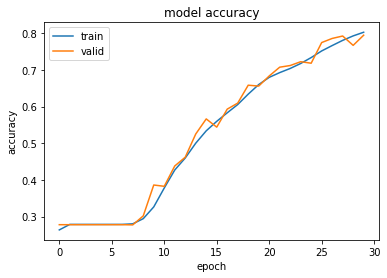

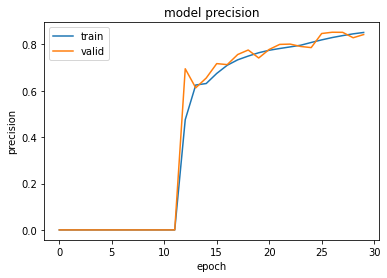

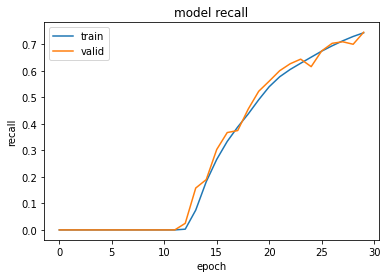

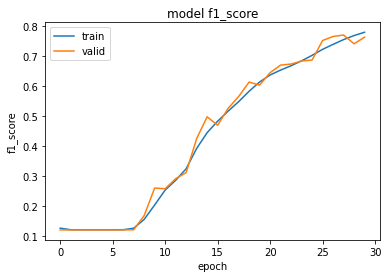

In [ ]:
print(history_img_paper1.history.keys())
plt.plot(history_img_paper1.history['categorical_accuracy'])
plt.plot(history_img_paper1.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(history_img_paper1.history['precision'])
plt.plot(history_img_paper1.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(history_img_paper1.history['recall'])
plt.plot(history_img_paper1.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


plt.plot(history_img_paper1.history['f1_score'])
plt.plot(history_img_paper1.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
model_img_paper2 = model_paper(32,32)
model_img_paper2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 30, 30, 8)         80        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 15, 15, 8)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 13, 13, 16)        1168      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 32)          4640      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 128)              

In [ ]:
f1_paper_callback2 = ModelCheckpoint("Saved Model/Paper/UP_2_32.hdf5",
                              monitor='val_f1_score',
                              verbose=1,
                              save_best_only=True,
                              mode='max')

history_img_paper2 = model_img_paper2.fit(
                                X_train_2_scaled,Y_train_2,
                                epochs=30,
                                batch_size=  100,
                                validation_data=(X_val_2_scaled,Y_val_2),
                                callbacks = [f1_paper_callback2 ]
                )


Epoch 1/30
1549/1549 [==============================] - 39s 25ms/step - loss: 2.6647 - categorical_accuracy: 0.2663 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.1265 - val_loss: 2.3155 - val_categorical_accuracy: 0.2777 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.1207

Epoch 00001: val_f1_score improved from -inf to 0.12075, saving model to Saved Model/Paper/UP_2_32.hdf5
Epoch 2/30
1549/1549 [==============================] - 39s 25ms/step - loss: 2.2366 - categorical_accuracy: 0.3451 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.2350 - val_loss: 2.1299 - val_categorical_accuracy: 0.5333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.4336

Epoch 00002: val_f1_score improved from 0.12075 to 0.43361, saving model to Saved Model/Paper/UP_2_32.hdf5
Epoch 3/30
1549/1549 [==============================] - 39s 25ms/step - loss: 1.8845 - categorical_accuracy: 0.6418 - precision: 0.8738 - recall: 0.1497 - f1_score: 0.

In [ ]:
print("best model: ")
model_img_paper2.load_weights("Saved Model/Paper/UP_2_32.hdf5")
print(model_img_paper2.evaluate(X_val_2_scaled, Y_val_2))
print(model_img_paper2.evaluate(X_test_2_scaled, Y_test_2))

best model: 
1614/1614 [==============================] - 7s 4ms/step - loss: 0.5303 - categorical_accuracy: 0.8822 - precision: 0.9028 - recall: 0.8609 - f1_score: 0.8603
[0.530326783657074, 0.8821843266487122, 0.9027644991874695, 0.8609340786933899, 0.8602725267410278]
1614/1614 [==============================] - 7s 4ms/step - loss: 0.5296 - categorical_accuracy: 0.8825 - precision: 0.9033 - recall: 0.8613 - f1_score: 0.8607
[0.5296090841293335, 0.8824554681777954, 0.9032624959945679, 0.8613215088844299, 0.8606771230697632]


dict_keys(['loss', 'categorical_accuracy', 'precision', 'recall', 'f1_score', 'val_loss', 'val_categorical_accuracy', 'val_precision', 'val_recall', 'val_f1_score'])


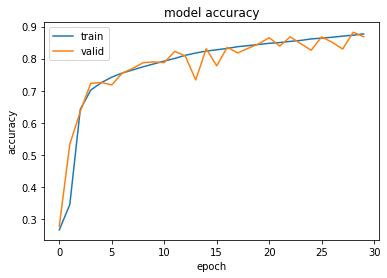

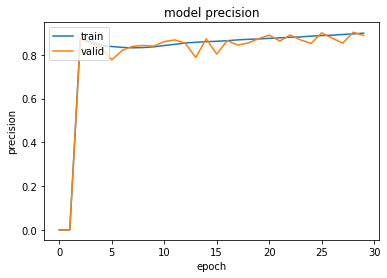

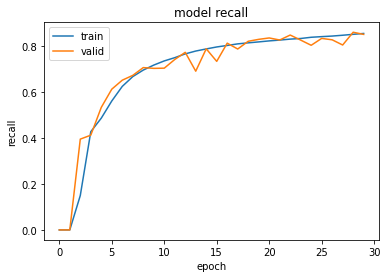

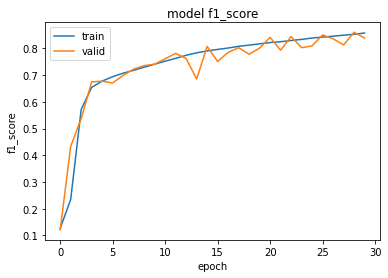

In [ ]:
print(history_img_paper2.history.keys())
plt.plot(history_img_paper2.history['categorical_accuracy'])
plt.plot(history_img_paper2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(history_img_paper2.history['precision'])
plt.plot(history_img_paper2.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(history_img_paper2.history['recall'])
plt.plot(history_img_paper2.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


plt.plot(history_img_paper2.history['f1_score'])
plt.plot(history_img_paper2.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()